November: The final notebook used to create a domain, create a coordinate grid, extract the realistic bathymetry, and create the corresponding idealized bathymetry.

In [1]:
import scipy as sc, scipy.io
import numpy as np
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized
import functions_grid
import functions_realistic
import functions_plot

from netCDF4 import Dataset

# Variables

In [2]:
#doubling resolution Jan 26
#quadrupling resolution Jun 28
x_final =  483#120 * 4
y_final =  363#int(0.75 * x_final)

extension_m = 80000#108061

smooth_factor = 0.2
max_norm_depth_diff = 0.70834736504

search_x = [-1000000, -1450000, -1750000, -1400000]

In [3]:
x_final, y_final

(483, 363)

# Set up

In [4]:
x_region, y_region, z_region = functions_plot.def_regionS()
cmap, norm = functions_plot.Colormap()

In [5]:
x_wall, y_wall, fluid_depth = functions_idealized.base_measurements()

# 2. Base Region

In [6]:
lon_s_corners_can, lat_s_corners_can = functions_grid.match_domain(x_wall, y_wall, search_x)

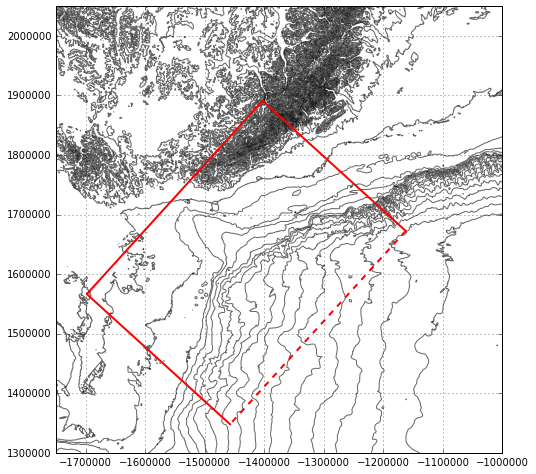

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.plot(lon_s_corners_can, lat_s_corners_can, 'r', linewidth=2)
ax.plot(lon_s_corners_can[::3], lat_s_corners_can[::3], 'r', linewidth=2, linestyle='--')

# 3. Extended Region

In [8]:
x_wall_ext = x_wall + extension_m

In [9]:
lon_s_corners, lat_s_corners = functions_grid.match_domain(x_wall_ext, y_wall, search_x)

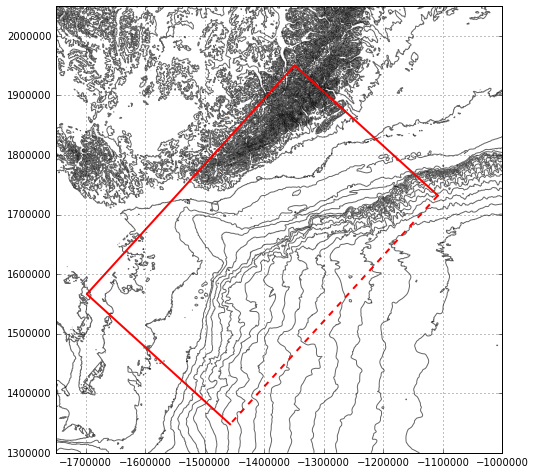

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.plot(lon_s_corners, lat_s_corners, 'r', linewidth=2)
ax.plot(lon_s_corners[::3], lat_s_corners[::3], 'r', linewidth=2, linestyle='--')

# 4. Extended Coordinates

In [11]:
lon_g_corners, lat_g_corners = functions_grid.transform_coords(lon_s_corners, lat_s_corners, 'SG')

lonW, latW, lonE, latE = functions_grid.get_southern_points(lon_g_corners, lat_g_corners)

lon_g_grid, lat_g_grid = functions_grid.create_grid(x_final, y_final, lonW, latW, lonE, latE)

lon_s_grid, lat_s_grid = functions_grid.transform_coords(lon_g_grid, lat_g_grid, 'GS')

dx (distance between the corner southern point and its neighbour) [km]: 1.0538988645
dx2 (distance between the corner northern point and its neighbour) [km]: 1.05201120598


(483, 363)

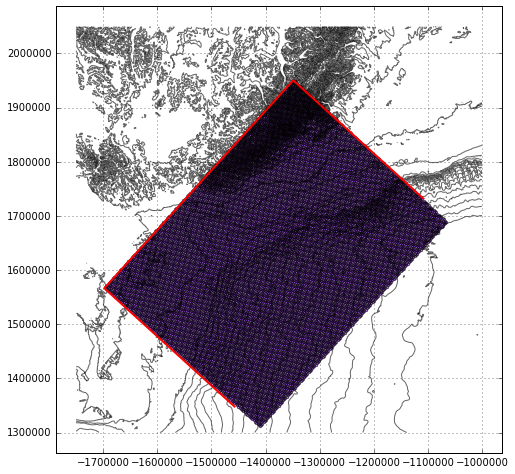

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.scatter(lon_s_grid[::3,::3], lat_s_grid[::3,::3], c='BlueViolet', s=5, alpha=0.6)
ax.plot(lon_s_corners, lat_s_corners, 'r', linewidth=2)
lon_s_grid.shape

# 5. Extended (Real) Bathymetry

In [23]:
dx = functions_grid.find_dx(lon_g_grid, lat_g_grid)
index = int(extension_m / (dx * 1000))

print(dx)

1.05206473248


In [14]:
z_positive = functions_realistic.canyon_for_model(fluid_depth, index, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

z_positive.shape

(360, 480)

In [ ]:
z_original, z_smoothed = functions_realistic.smooth_canyon(max_norm_depth_diff, smooth_factor, z_positive)

z_smoothed.shape

In [ ]:
difference = np.subtract(z_smoothed, z_original)
fig, axes = plt.subplots(1,3,figsize=(14,3.5)); plt.tight_layout()
c0 = axes[0].contourf(z_original, 50, cmap = cmo.cm.matter)
c1 = axes[1].contourf(z_smoothed, 50, cmap = cmo.cm.matter)
c2 = axes[2].pcolormesh(difference, cmap = cm.seismic, vmin=-80, vmax=80)
axes[0].contour(z_original, 25, linestyles='solid', colors = 'k')
axes[1].contour(z_smoothed, 25, linestyles='solid', colors = 'k')
axes[2].contour(z_original, levels = [0, 40, 80, 1299], colors='k',linestyles='-')
for cs, i, ttl in zip([c0, c1, c2], np.arange(3), ['original', 'smoothed', 'difference']):
    fig.colorbar(cs, ax = axes[i]); axes[i].set_title(ttl)
    axes[i].xaxis.set_visible(False); axes[i].yaxis.set_visible(False)

# 7. Idealized Canyon

In [15]:
x_wall, y_wall = functions_idealized.extended_measurements(lon_s_grid, lat_s_grid)

x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(x_wall, y_wall)

In [16]:
xsize, ysize = x_final-2, y_final-2

x, y, y_edge, X, Y = functions_idealized.set_domain_grid(xsize, ysize, x_wall, y_wall)

z_ideal = functions_idealized.make_topo_smooth(y_edge, y_base, y_paral, y_pointA, y_pointB, y_break, y_head, y_coast,
                                               cR, L, p, x, x_wall, w_break, w_mid, w_head,
                                               fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast)

(360, 480)

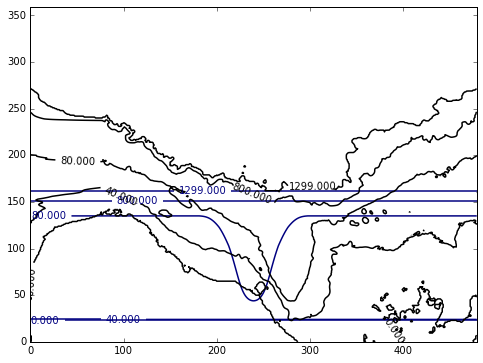

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

c1 = ax.contour(z_ideal, levels = [0, 40, 80, 800, 1299], colors='Navy', linewidths=1.5)
c2 = ax.contour(z_positive, levels = [0, 40, 80, 800, 1299], colors='k', linewidths=1.5)
ax.clabel(c1, inline=1, fontsize=10)
ax.clabel(c2, inline=1, fontsize=10)
z_ideal.shape

# 8. Make files

1. Coordinates Grid 
2. Idealized canyon bathymetry

In [ ]:
filename = 'real_bathy_quad.nc'
title = 'Realistic Bathymetry Version 03'
description = '480x360 (Quad Res). Extended on the west by 80 km and dx ~ 1.05 km. Smoothed.'
ipynbname = 'final_bathymetry.ipynb'
functions_realistic.create_bathy_file(z_smoothed, filename, title, description, ipynbname)

** Values for refine_mackenzie.ipynb:**

In [26]:
xsize, ysize, x_wall, y_wall

(481, 361, 518899.79764883459, 386541.17506205867)

In [27]:
! ls /ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/

ideal_bathy_01.nc  ideal_bathy_03.nc  ideal_bathy_05.nc    tiniest_bathy.nc
ideal_bathy_02.nc  ideal_bathy_04.nc  ideal_bathy_quad.nc  tiny_bathy.nc


In [28]:
! ls /ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/

real_bathy_01.nc  real_bathy_02.nc


In [29]:
! ls /ocean/imachuca/Canyons/mackenzie_canyon/coordinates/raw_coordinates/

grid_01.nc  grid_02.nc	grid_quad.nc
